<a href="https://colab.research.google.com/github/awjumangit/sample_project/blob/master/brunei_multivariate_lstm_20210510.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Setup

## Define variables 

In [81]:
# filepath = "BRUNEI\Brunei_forLSTM_daily_0501.xlsx"
gdrive_folder = "/content/drive/MyDrive/Colab Notebooks/BRUNEI/"
filepath = gdrive_folder + "BRUNEI/Brunei_forLSTM_daily_0501.xlsx"
skiprows = range(1,400)                   # Define which rows to skip (rows 1 to 180)
skipfooter = 0                          # Define the number of last n rows to skip

log_transform_columns = []
rev_log_transform_columns = []
drop_columns = ['WazeMob',
       'TotVaccDoses', 'TotVaccPop',
       'vaccpopsh', 'fullyvaccpopsh',
       'GooRR', 'GooGP', 'GooP', 'GooTS', 'GooWork', 'GooRes', 'AppDri',
       'AppTran', 'AppWalk',
      #  'MALTotVaccDoses',
       'MALTotVaccPop',
       'MALvaccpopsh', 'MALfullyvaccpopsh',
       'PHITotVaccDoses',
        'PHIfullyvac', 
       'PHIvaccpopsh', 'PHIfullyvaccpopsh', 
      #  'SINTotVaccDoses', 'SINTotVaccPop', 
       'SINvaccpopsh', 'SINfullyvaccpopsh', 
      #  'AUSTotVaccDoses',
       'AUSTotVaccPop', 
       'AUSvaccpopsh', 'AUSfullyvaccpopsh', 
      #  'UKTotVaccDoses', 'UKTotVaccPop',
       'UKvaccpopsh', 'UKfullyvaccpopsh',
        'PPIndex', 'PERatio', 'EquiInd']
drop_columns = drop_columns + ['OSOr','OSDes', 'GDP', 'Llights', 'NewCas1']

target_var = 'OSTotal'

test_size = 20

n_future = 150   # Number of obs we want to predict into the future #Redefining n_future to extend prediction dates beyond original n_future dates...
n_past = 200    # Number of past obs we want to use to predict the future

param_grid = {
    'epochs': [10,20], 
    'batch_size': [10,20],
    'optimizer': ['Adam']
}

lr = 0.0005

## Import packages 

In [82]:
!pip install keras-hypetune

In [83]:
!pip install lime

In [84]:
# -*- coding: utf-8 -*-
"""
Created on Mon Feb  8 21:07:35 2021

Compiled by Geraldine through various sources.

Key references:
    https://github.com/bnsreenu/python_for_microscopists/blob/master/181_multivariate_timeseries_LSTM_GE.py
    https://github.com/krishnaik06/Stock-Market-Forecasting
    https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
    https://towardsdatascience.com/visualizing-artificial-neural-networks-anns-with-just-one-line-of-code-b4233607209e
"""

from datetime import datetime
import datetime as dt
import random
import os
random.seed(1234)
import csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from statsmodels.tsa.stattools import adfuller
from scipy import stats

import tensorflow as tf 
tf.random.set_seed(1234)

from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed, Dropout
from keras.optimizers import RMSprop, SGD
from keras.wrappers.scikit_learn import KerasRegressor
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from kerashypetune import KerasGridSearch

from sklearn.metrics import mean_squared_error, mean_squared_error, mean_absolute_error
# , mean_absolute_percentage_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# import shap

pd.set_option('display.max_columns', 500)

## Load dataset 

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
# singapore
df = pd.read_excel(filepath \
                   , skipfooter=skipfooter, skiprows=skiprows
                  )
df.tail()

,Date,OSOr,OSDes,OSTotal,WazeMob,NewCas1,NewCas,TotCas,NewDea,TotDea,TotVaccDoses,TotVaccPop,vaccpopsh,fullyvaccpopsh,R0,R01,R02,GooRR,GooGP,GooP,GooTS,GooWork,GooRes,AppDri,AppTran,AppWalk,MALTotVaccDoses,MALTotVaccPop,MALvaccpopsh,MALfullyvaccpopsh,MALR0,PHITotVaccDoses,PHIfullyvac,PHIvaccpopsh,PHIfullyvaccpopsh,PHIR0,SINTotVaccDoses,SINTotVaccPop,SINvaccpopsh,SINfullyvaccpopsh,SINR0,AUSTotVaccDoses,AUSTotVaccPop,AUSvaccpopsh,AUSfullyvaccpopsh,AUSR0,UKTotVaccDoses,UKTotVaccPop,UKvaccpopsh,UKfullyvaccpopsh,UKR0,ExchRate,GDP,LGDP,GovtExpHealth,PPIndex,PERatio,EquiInd,Lights,Llights,ChangeLights,Sindex
417,2021-03-27,1,1,2,NaN,0.0,0.0,206.0,0.0,3.0,NaN,NaN,NaN,NaN,0.085000,0.478270,0.204973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,566200.0,118013.0,1.749367,0.364620,0.93,656331.000000,NaN,0.598946,0.000000,1.30,1.248941e+06,310000.0,21.348173,5.298835,1.27,506465.0,NaN,1.986147,0.0,1.11,33684114.0,3532378.0,49.618643,5.203397,0.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.042229,0.041362,0.0,40.74
418,2021-03-28,1,2,3,NaN,0.0,1.0,206.0,0.0,3.0,NaN,NaN,NaN,NaN,0.042500,0.478270,0.204973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,580765.0,129110.0,1.794368,0.398906,0.94,679925.857143,NaN,0.620477,0.000000,1.29,1.283927e+06,310000.0,21.946178,5.298835,1.30,511520.0,NaN,2.005970,0.0,1.13,34125256.0,3679972.0,50.268471,5.420811,0.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.042229,0.041362,0.0,40.74
419,2021-03-29,1,1,2,NaN,0.0,0.0,206.0,0.0,3.0,NaN,NaN,NaN,NaN,0.021250,0.478270,0.204973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,621417.0,159510.0,1.919969,0.492832,0.96,679925.857143,NaN,0.620477,0.000000,1.28,1.318912e+06,375605.0,22.544182,6.420222,1.36,541761.0,NaN,2.124563,0.0,1.13,34530295.0,3848202.0,50.865116,5.668624,0.84,1.3378,NaN,NaN,NaN,NaN,NaN,NaN,1.042229,0.041362,0.0,40.74
420,2021-03-30,5,4,9,NaN,0.0,3.0,206.0,0.0,3.0,NaN,NaN,NaN,NaN,0.010625,0.471526,0.202083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,661661.0,188385.0,2.044309,0.582046,0.97,738913.000000,1344.0,0.674307,0.001226,1.26,1.318912e+06,375605.0,22.544182,6.420222,1.40,597523.0,NaN,2.343238,0.0,1.08,35033894.0,4125884.0,51.606947,6.077665,0.81,1.3395,NaN,NaN,NaN,NaN,NaN,NaN,1.042229,0.041362,0.0,40.74
421,2021-03-31,4,5,9,NaN,0.0,2.0,206.0,0.0,3.0,NaN,NaN,NaN,NaN,0.000000,0.471526,0.202083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,698203.0,215395.0,2.157211,0.665498,0.99,NaN,NaN,0.000000,0.000000,1.24,1.318912e+06,375605.0,22.544182,6.420222,1.40,670349.0,NaN,2.628832,0.0,1.06,35660902.0,4513458.0,52.530566,6.648584,0.79,1.3374,NaN,NaN,NaN,NaN,NaN,NaN,1.042229,0.041362,0.0,40.74


In [87]:
print("Dataset has :", df.shape[0], "rows")
print("Dataset has :", df.shape[1], "columns / variables")

Dataset has : 422 rows
Dataset has : 62 columns / variables


## Create output folder 

In [89]:
# datetime object containing current date and time
now = datetime.now()
timestamp = now.strftime("%Y-%m-%d_%H-%M")
directory = gdrive_folder + "/multivariate_" + timestamp
os.mkdir(directory)
print("Directory '% s' created" % directory)


FileExistsError: ignored

# Explore dataset 

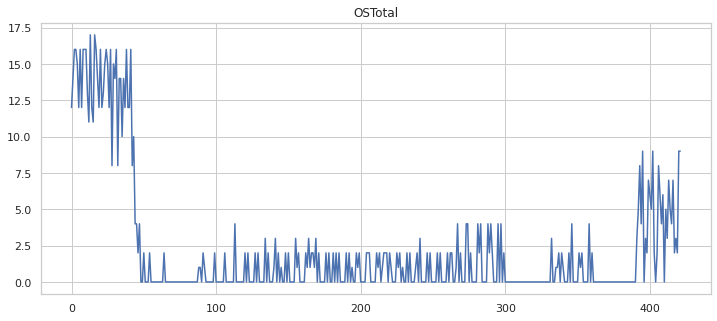

In [90]:
plot1 = df[target_var].plot(figsize=(12,5))
plt.title(target_var)
plt.savefig('{directory}/target_var_{target_var}.png'.format(directory=directory, target_var=target_var), dpi=300)

In [91]:
df.dtypes.to_frame().T

,Date,OSOr,OSDes,OSTotal,WazeMob,NewCas1,NewCas,TotCas,NewDea,TotDea,TotVaccDoses,TotVaccPop,vaccpopsh,fullyvaccpopsh,R0,R01,R02,GooRR,GooGP,GooP,GooTS,GooWork,GooRes,AppDri,AppTran,AppWalk,MALTotVaccDoses,MALTotVaccPop,MALvaccpopsh,MALfullyvaccpopsh,MALR0,PHITotVaccDoses,PHIfullyvac,PHIvaccpopsh,PHIfullyvaccpopsh,PHIR0,SINTotVaccDoses,SINTotVaccPop,SINvaccpopsh,SINfullyvaccpopsh,SINR0,AUSTotVaccDoses,AUSTotVaccPop,AUSvaccpopsh,AUSfullyvaccpopsh,AUSR0,UKTotVaccDoses,UKTotVaccPop,UKvaccpopsh,UKfullyvaccpopsh,UKR0,ExchRate,GDP,LGDP,GovtExpHealth,PPIndex,PERatio,EquiInd,Lights,Llights,ChangeLights,Sindex
0,datetime64[ns],int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [92]:
df.describe()

,OSOr,OSDes,OSTotal,WazeMob,NewCas1,NewCas,TotCas,NewDea,TotDea,TotVaccDoses,TotVaccPop,vaccpopsh,fullyvaccpopsh,R0,R01,R02,GooRR,GooGP,GooP,GooTS,GooWork,GooRes,AppDri,AppTran,AppWalk,MALTotVaccDoses,MALTotVaccPop,MALvaccpopsh,MALfullyvaccpopsh,MALR0,PHITotVaccDoses,PHIfullyvac,PHIvaccpopsh,PHIfullyvaccpopsh,PHIR0,SINTotVaccDoses,SINTotVaccPop,SINvaccpopsh,SINfullyvaccpopsh,SINR0,AUSTotVaccDoses,AUSTotVaccPop,AUSvaccpopsh,AUSfullyvaccpopsh,AUSR0,UKTotVaccDoses,UKTotVaccPop,UKvaccpopsh,UKfullyvaccpopsh,UKR0,ExchRate,GDP,LGDP,GovtExpHealth,PPIndex,PERatio,EquiInd,Lights,Llights,ChangeLights,Sindex
count,422.000000,422.000000,422.000000,0.0,388.000000,388.000000,388.000000,369.000000,369.000000,0.0,0.0,0.0,0.0,372.000000,149.000000,149.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.000000,14.000000,33.000000,33.000000,387.000000,31.000000,1.0,31.000000,31.000000,382.000000,8.000000e+01,64.000000,80.000000,80.000000,396.000000,38.000000,0.0,38.000000,38.0,386.000000,8.800000e+01,8.800000e+01,88.000000,88.000000,394.000000,286.000000,332.000000,332.000000,3.320000e+02,0.0,0.0,0.0,422.000000,422.000000,417.000000,422.000000
mean,1.175355,1.123223,2.298578,NaN,0.530928,0.546392,149.180412,0.008130,2.620596,NaN,NaN,NaN,NaN,0.164756,0.266151,0.114065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,333503.468750,85603.928571,0.999188,0.112207,1.117003,267918.566820,1344.0,0.244493,0.000040,1.132147,4.684108e+05,145480.296875,8.006553,1.989358,1.027045,199232.026316,NaN,0.781306,0.0,1.026917,1.642980e+07,1.157748e+06,24.202041,1.705430,1.114213,1.362158,2973.761363,7.996006,3.744000e+02,NaN,NaN,NaN,0.946756,-0.052936,-0.005275,40.284953
std,2.151630,2.143095,4.262296,NaN,2.107345,2.111960,28.453024,0.089922,0.749789,NaN,NaN,NaN,NaN,0.257900,0.223506,0.095788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,198470.368626,70538.612318,0.629639,0.192138,0.319762,239989.936271,NaN,0.219007,0.000220,0.270391,3.926025e+05,121679.554624,6.710761,2.109893,0.335088,185509.765222,NaN,0.727493,0.0,0.415402,1.016366e+07,9.766603e+05,14.971665,1.438677,0.429281,0.033413,170.152814,0.055772,2.163310e-12,NaN,NaN,NaN,0.183830,0.141174,0.162790,10.020467
min,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,1.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,0.000000,0.007000,0.003000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3580.000000,792.000000,0.000000,0.000000,0.570000,0.000000,1344.0,0.000000,0.000000,0.840000,3.400000e+03,50.000000,0.058116,0.000000,0.490000,20.000000,NaN,0.000078,0.0,0.390000,1.402432e+06,2.200200e+04,2.065863,0.032410,0.500000,1.306900,2808.872465,7.940538,3.744000e+02,NaN,NaN,NaN,0.000000,-0.383858,-1.000000,19.440000
25%,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,141.000000,0.000000,3.000000,NaN,NaN,NaN,NaN,0.000000,0.030208,0.012946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,159702.250000,19991.250000,0.431688,0.000000,0.890000,36633.000000,1344.0,0.033430,0.000000,0.962500,1.445500e+05,6000.000000,2.470795,0.000855,0.810000,53382.000000,NaN,0.209342,0.0,0.762500,7.255342e+06,4.934200e+05,10.687537,0.726836,0.812500,1.333200,2808.872465,7.940538,3.744000e+02,NaN,NaN,NaN,0.862470,-0.142794,-0.044304,35.190000
50%,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,145.000000,0.000000,3.000000,NaN,NaN,NaN,NaN,0.020000,0.230461,0.098769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,333919.500000,83923.000000,0.992804,0.000000,1.080000,215997.000000,1344.0,0.197112,0.000000,1.050000,3.825053e+05,110000.000000,6.538169,1.880232,0.980000,147198.500000,NaN,0.577252,0.0,0.940000,1.631091e+07,6.335565e+05,24.026912,0.933265,1.040000,1.358550,2888.080784,7.968347,3.744000e+02,NaN,NaN,NaN,0.905440,-0.094701,-0.000103,37.960000
75%,1.000000,1.000000,2.000000,NaN,0.000000,0.000000,152.000000,0.000000,3.000000,NaN,NaN,NaN,NaN,0.190000,0.478270,0.204973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,489235.750000,126335.750000,1.489183,0.161036,1.200000,447019.142857,1344.0,0.407935,0.000000,1.200000,6.954003e+05,243169.000000,11.886488,3.738140,1.162500,275892.750000,NaN,1.081937,0.0,1.220000,2.414944e+

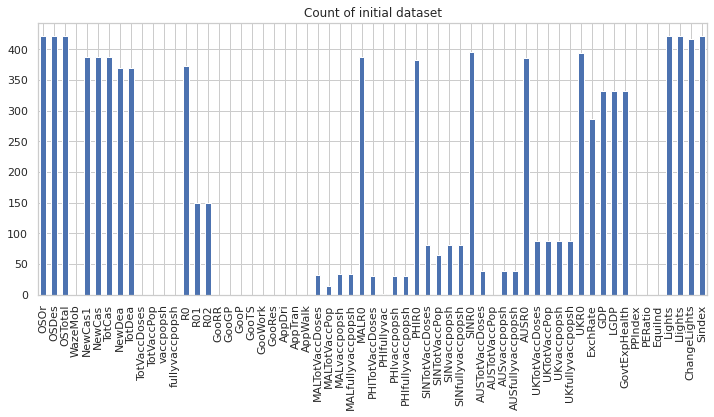

In [93]:
df.describe().T['count'].plot(kind='bar', figsize=(12,5))
plt.title('Count of initial dataset')
plt.savefig('{directory}/initial_dataset.png'.format(directory=directory), dpi=300, bbox_inches = 'tight', pad_inches=1)

In [94]:
df.describe().T['count'][df.describe().T['count'] < 100].to_frame().index

Index(['WazeMob', 'TotVaccDoses', 'TotVaccPop', 'vaccpopsh', 'fullyvaccpopsh',
       'GooRR', 'GooGP', 'GooP', 'GooTS', 'GooWork', 'GooRes', 'AppDri',
       'AppTran', 'AppWalk', 'MALTotVaccDoses', 'MALTotVaccPop',
       'MALvaccpopsh', 'MALfullyvaccpopsh', 'PHITotVaccDoses', 'PHIfullyvac',
       'PHIvaccpopsh', 'PHIfullyvaccpopsh', 'SINTotVaccDoses', 'SINTotVaccPop',
       'SINvaccpopsh', 'SINfullyvaccpopsh', 'AUSTotVaccDoses', 'AUSTotVaccPop',
       'AUSvaccpopsh', 'AUSfullyvaccpopsh', 'UKTotVaccDoses', 'UKTotVaccPop',
       'UKvaccpopsh', 'UKfullyvaccpopsh', 'PPIndex', 'PERatio', 'EquiInd'],
      dtype='object')

## Visualize timeseries data 

In [95]:
# df.plot(subplots=True, figsize=(15,100))
# plt.show()

## Check for correlation 

In [96]:
# for col in df.columns: 
#     if col not in ['Date', target_var]:
#         sns.scatterplot(col,target_var,data=df)
#         plt.show()

In [97]:
# round(df.corr(),2)

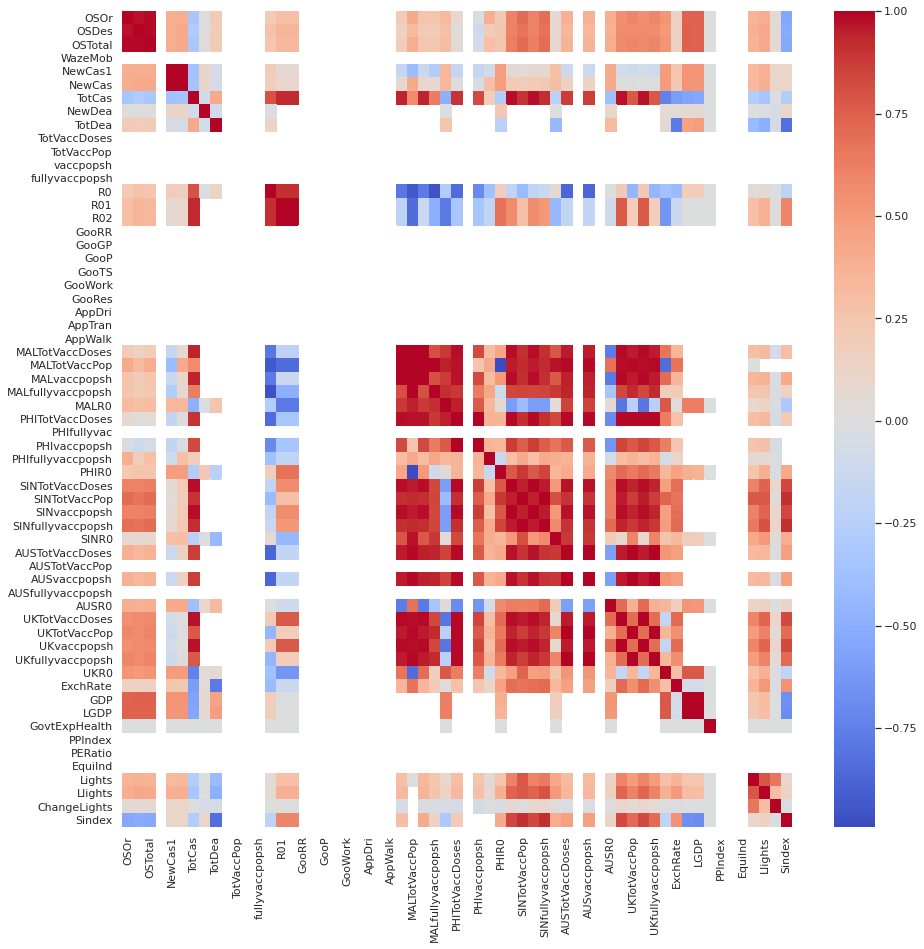

In [98]:
# sns.color_palette("vlag", as_cmap=True)
plt.figure(figsize=(15,15))
corrMatrix = round(df.corr(),2)
sns.heatmap(corrMatrix, cmap='coolwarm')
plt.savefig('{directory}/corr_heatmap.png'.format(directory=directory), dpi=300, bbox_inches = 'tight', pad_inches=1)
plt.show()

In [100]:
correlation_vars = []
print("Variables with high positive/negative correlation with the target variable:", target_var, "\n")
for col in df.columns: 
    if col not in ['Date', target_var]:
        # sns.scatterplot(col,target_var,data=df)
        # plt.show()
        r_pearson, p_value_pearson = scipy.stats.pearsonr(df[col].fillna(0), df[target_var].fillna(0))
        if abs(r_pearson) > .6 : 
          print("Pearson's r for:", col, "=", r_pearson)    # Pearson's r. 
          correlation_vars.append(col)
        # scipy.stats.spearmanr(df[col], df[target_var])   # Spearman's rho  
        # scipy.stats.kendalltau(df[col], df[target_var])  # Kendall's tau
        

Variables with high positive/negative correlation with the target variable: OSTotal 

Pearson's r for: OSOr = 0.992479382660463
Pearson's r for: OSDes = 0.9924191341897994
Pearson's r for: TotCas = -0.7720993342615513
Pearson's r for: PHIR0 = -0.6232713586113809


An input array is constant; the correlation coefficent is not defined.


## Detect Nonlinearities
* Pearson correlation is a measure of linear relationship, assumes normal distribution. varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact linear relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases. It is sensitive to outliers.

In [101]:
import scipy.stats


In [102]:
# load data (kindly edit wrt dataset) below is sample data
x = np.arange(10, 20)
y = np.array([2, 1, 4, 5, 8, 12, 18, 25, 96, 48])

In [103]:
# Results will throw two values. The first one is the correlation, the second one is the p-value
scipy.stats.pearsonr(x, y)    # Pearson's r. 
scipy.stats.spearmanr(x, y)   # Spearman's rho 
scipy.stats.kendalltau(x, y)  # Kendall's tau


KendalltauResult(correlation=0.911111111111111, pvalue=2.9761904761904762e-05)

## Stationary test 
* If the result is less than the p-value, we reject the null , therefore classify the timeseries as stationary. Note that stationarity is a desirable timeseries characteristics. It tells us that the ts data's properties do not change over time. This is especially important for traditional forecasting models. 
* For LSTM, we do not need to check for stationarity nor correct for it (https://stanford.edu/~koenecke/files/Deep_Learning_for_Time_Series_Tutorial.pdf)

##### Few more details: 
* The Augmented Dickey Fuller Test (ADF) is unit root test for stationarity. Unit roots can cause unpredictable results in your time series analysis.

* The hypotheses for the test:

* Ho for this test is that there is a unit root.(non-stationary--not desirable, remedy is differencing)

* Ha is that the time series is stationary (or trend-stationary--what we want a TS should have).

* For ADF, we need to choose a lag length to run the test. The lag length should be chosen so that the residuals aren’t serially correlated. You’ve got several options for choosing lags: Minimize Akaike’s information criterion (AIC) or Bayesian information criterion (BIC), or drop lags until the last lag is statistically significant.

* If time series is non-stationary, are unpredictable and cannot be modeled or forecasted. The data has to be transformed (such as by differencing the data).

In [104]:
# non_stationary=[]
# stationary=[]
# for col in df.columns: 
#     if col not in ['Date', target_var]:
#         series =  df[col].fillna(0).values

# #         plt.figure(figsize=(14,8))
#         df[col].to_frame().plot(title=col, figsize=(15,5))
# #         plt.title(col)
#         plt.show()
#         # ADF Test
#         result = adfuller(series, autolag='AIC')
#         p_value = result[1]
#         print(f'p-value: {result[1]}')
#         if p_value > .05 : 
#             print(" Accept the null hypothesis (H0), the data has a unit root and is non-stationary.")
#             non_stationary.append(col)
#         if p_value <= .05 : 
#             print("Reject the null hypothesis (H0), the data does not have a unit root and is stationary.")
#             stationary.append(col)

In [105]:
# non_stationary

In [106]:
# stationary

# Clean dataset

## Fill missing data with interpolation 

In [107]:
df = df.interpolate(method='linear', limit_direction='forward', axis=0)

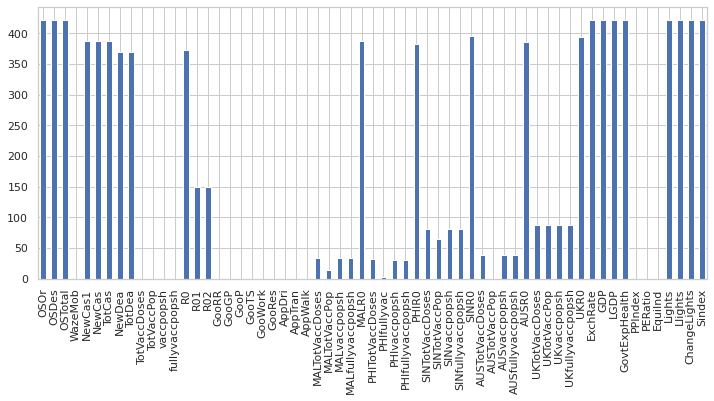

In [108]:
df.describe().T['count'].plot(kind='bar', figsize=(12,5))
plt.show()

In [109]:
df.describe().T['count'].to_frame().T

,OSOr,OSDes,OSTotal,WazeMob,NewCas1,NewCas,TotCas,NewDea,TotDea,TotVaccDoses,TotVaccPop,vaccpopsh,fullyvaccpopsh,R0,R01,R02,GooRR,GooGP,GooP,GooTS,GooWork,GooRes,AppDri,AppTran,AppWalk,MALTotVaccDoses,MALTotVaccPop,MALvaccpopsh,MALfullyvaccpopsh,MALR0,PHITotVaccDoses,PHIfullyvac,PHIvaccpopsh,PHIfullyvaccpopsh,PHIR0,SINTotVaccDoses,SINTotVaccPop,SINvaccpopsh,SINfullyvaccpopsh,SINR0,AUSTotVaccDoses,AUSTotVaccPop,AUSvaccpopsh,AUSfullyvaccpopsh,AUSR0,UKTotVaccDoses,UKTotVaccPop,UKvaccpopsh,UKfullyvaccpopsh,UKR0,ExchRate,GDP,LGDP,GovtExpHealth,PPIndex,PERatio,EquiInd,Lights,Llights,ChangeLights,Sindex
count,422.0,422.0,422.0,0.0,388.0,388.0,388.0,369.0,369.0,0.0,0.0,0.0,0.0,372.0,149.0,149.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,14.0,33.0,33.0,387.0,32.0,2.0,31.0,31.0,382.0,80.0,64.0,80.0,80.0,396.0,38.0,0.0,38.0,38.0,386.0,88.0,88.0,88.0,88.0,394.0,422.0,422.0,422.0,422.0,0.0,0.0,0.0,422.0,422.0,422.0,422.0


## Fill na values with -1

In [110]:
df = df.fillna(-1)

## Log transform columns 

In [111]:
df[log_transform_columns] = np.log(df[log_transform_columns])
df[log_transform_columns].head()

""
0
1
2
3
4


## Reverse log transform columns 

In [112]:
df[rev_log_transform_columns] = np.exp(df[rev_log_transform_columns])
df[rev_log_transform_columns].head()

""
0
1
2
3
4


## Drop columns 

In [113]:
df = df.drop(columns = drop_columns)
df.head()

,Date,OSTotal,NewCas,TotCas,NewDea,TotDea,R0,R01,R02,MALTotVaccDoses,MALR0,PHIR0,SINTotVaccDoses,SINTotVaccPop,SINR0,AUSTotVaccDoses,AUSR0,UKTotVaccDoses,UKTotVaccPop,UKR0,ExchRate,LGDP,GovtExpHealth,Lights,ChangeLights,Sindex
0,2020-02-04,12,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.362200,8.103239,374.4,1.196030,0.302497,19.44
1,2020-02-05,14,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.371200,8.103239,374.4,1.019888,-0.147272,19.44
2,2020-02-06,16,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.374800,8.103239,374.4,1.069461,0.048607,19.44
3,2020-02-07,16,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.376800,8.103239,374.4,1.031298,-0.035685,19.44
4,2020-02-08,15,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.378733,8.103239,374.4,0.924040,-0.104003,19.44


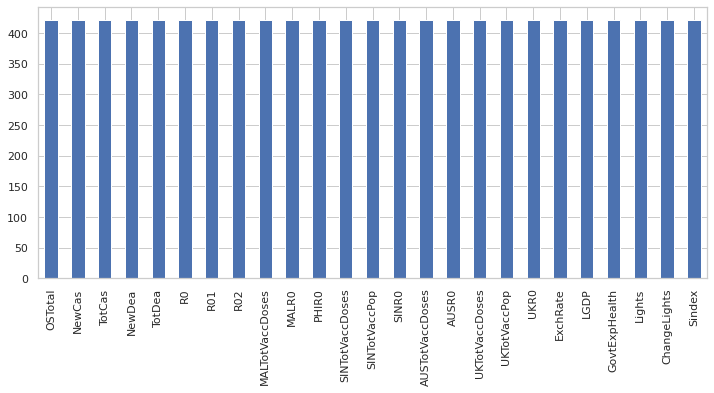

In [114]:
df.describe().T['count'].plot(kind='bar', figsize=(12,5))
plt.show()

## Re-arrange columns 

In [115]:
df_cols = df.columns.tolist()
df_cols.remove('Date')
df_cols.remove(target_var)
new_cols = ['Date'] + df_cols + [target_var]
df = df[new_cols]
df.head()

,Date,NewCas,TotCas,NewDea,TotDea,R0,R01,R02,MALTotVaccDoses,MALR0,PHIR0,SINTotVaccDoses,SINTotVaccPop,SINR0,AUSTotVaccDoses,AUSR0,UKTotVaccDoses,UKTotVaccPop,UKR0,ExchRate,LGDP,GovtExpHealth,Lights,ChangeLights,Sindex,OSTotal
0,2020-02-04,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.362200,8.103239,374.4,1.196030,0.302497,19.44,12
1,2020-02-05,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.371200,8.103239,374.4,1.019888,-0.147272,19.44,14
2,2020-02-06,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.374800,8.103239,374.4,1.069461,0.048607,19.44,16
3,2020-02-07,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.376800,8.103239,374.4,1.031298,-0.035685,19.44,16
4,2020-02-08,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.378733,8.103239,374.4,0.924040,-0.104003,19.44,15


# Prepare dataset 

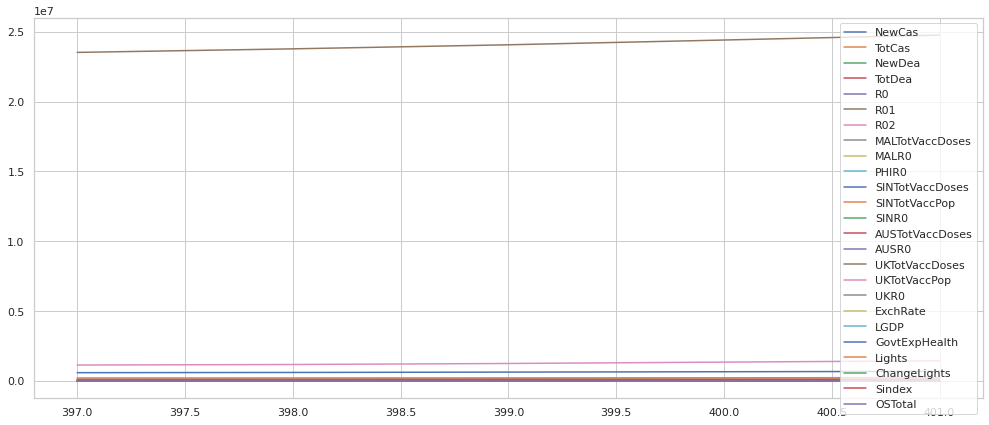

In [116]:
train_dates = pd.to_datetime(df[:-test_size]['Date'], format = '%d %m %Y')
test_dates =  pd.to_datetime(df[-test_size:]['Date'], format = '%d %m %Y')
df_for_training = df[:-test_size][new_cols[1:]].astype(float)

df_for_plot=df_for_training.tail()
df_for_plot.plot.line(figsize=(17,7))  

In [117]:
df_test =  df[-test_size:][new_cols[1:]].astype(float)
df_test.head()

,NewCas,TotCas,NewDea,TotDea,R0,R01,R02,MALTotVaccDoses,MALR0,PHIR0,SINTotVaccDoses,SINTotVaccPop,SINR0,AUSTotVaccDoses,AUSR0,UKTotVaccDoses,UKTotVaccPop,UKR0,ExchRate,LGDP,GovtExpHealth,Lights,ChangeLights,Sindex,OSTotal
402,0.0,192.0,0.0,3.0,0.77,0.606341,0.259860,275851.0,0.82,1.36,714804.857143,218694.0,0.94,135103.0,1.13,25216857.0,1532754.0,0.88,1.330800,8.012091,374.4,0.910577,-0.021855,40.74,9.0
403,0.0,192.0,0.0,3.0,0.76,0.606341,0.259860,292104.0,0.82,1.38,740677.571429,218694.0,0.98,159294.0,1.10,25781120.0,1584909.0,0.87,1.332367,8.012091,374.4,1.042229,0.144581,40.74,2.0
404,7.0,199.0,0.0,3.0,0.76,0.606341,0.259860,301699.0,0.82,1.39,766550.285714,218694.0,1.05,162551.0,1.10,26063501.0,1610280.0,0.87,1.333933,8.012091,374.4,1.042229,0.000000,40.74,0.0
405,0.0,199.0,0.0,3.0,0.75,0.606341,0.259860,321331.0,0.83,1.40,792423.000000,243169.0,1.06,164781.0,1.09,26503552.0,1663646.0,0.88,1.335500,8.012091,374.4,1.042229,0.000000,40.74,2.0
406,3.0,202.0,0.0,3.0,0.75,0.532861,0.228369,346508.0,0.83,1.40,832349.428571,243169.0,1.07,182437.0,1.10,27032671.0,1759445.0,0.89,1.336200,8.012091,374.4,1.042229,0.000000,40.74,8.0


In [118]:
# Normalize the dataset sensitivity of LSTM's sigmoid and tanh to magnitude of values
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)

df_for_training_scaled = scaler.transform(df_for_training)
df_test_scaled = scaler.transform(df_test)


## Reshape data, set number of observations for prediction 

In [119]:
## As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
trainX = []
trainY = []


for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, -1])

trainX, trainY = np.array(trainX), np.array(trainY)



In [120]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (53, 200, 25).
trainY shape == (53, 1).


# Define LSTM model

## Hyperparameter optimization 

In [121]:
def create_model(optimizer='adam'):
	# create model
  model = Sequential()
  model.add(LSTM(50, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
  model.add(LSTM(40, activation='relu', return_sequences=True))
  # model.add(LSTM(30, activation='relu', return_sequences=True))
  model.add(LSTM(20, activation='relu', return_sequences=True))
  model.add(LSTM(10, activation='relu', return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(trainY.shape[1]))
  # Compile model
  model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
    
    
  return model

In [122]:
# from keras.wrappers.scikit_learn import KerasClassifier

# model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=10, verbose=1)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
# grid_result = grid.fit(trainX, trainY)

# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

## Model fitting

In [123]:
model = create_model()

adam = optimizers.Adam(lr=lr)
# sgd = SGD(lr=0.0000001, decay=1e-6, momentum=0.9, nesterov=True,clipnorm=100)
# rmsprop = RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False)

model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 200, 50)           15200     
_________________________________________________________________
lstm_9 (LSTM)                (None, 200, 40)           14560     
_________________________________________________________________
lstm_10 (LSTM)               (None, 200, 20)           4880      
_________________________________________________________________
lstm_11 (LSTM)               (None, 10)                1240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 35,891
Trainable params: 35,891
Non-trainable params: 0
__________________________________________________

In [124]:
# patient early stopping (ADDED THIS)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

# fit model
history = model.fit(trainX, trainY, epochs=20, batch_size=10, validation_split=0.1, verbose=1, callbacks=[es])

Epoch 1/20
5/5 [==============================] - 7s 420ms/step - loss: 66.8085 - accuracy: 0.0000e+00 - val_loss: 0.4338 - val_accuracy: 0.0000e+00
Epoch 2/20
5/5 [==============================] - 1s 246ms/step - loss: 114.7832 - accuracy: 0.0000e+00 - val_loss: 0.4360 - val_accuracy: 0.0000e+00
Epoch 3/20
5/5 [==============================] - 1s 224ms/step - loss: 104.3749 - accuracy: 0.0000e+00 - val_loss: 0.4367 - val_accuracy: 0.0000e+00
Epoch 4/20
5/5 [==============================] - 1s 228ms/step - loss: 62.2031 - accuracy: 0.0000e+00 - val_loss: 0.4369 - val_accuracy: 0.0000e+00
Epoch 5/20
5/5 [==============================] - 1s 227ms/step - loss: 63.3856 - accuracy: 0.0000e+00 - val_loss: 0.4374 - val_accuracy: 0.0000e+00
Epoch 6/20
5/5 [==============================] - 1s 228ms/step - loss: 73.4324 - accuracy: 0.0000e+00 - val_loss: 0.4381 - val_accuracy: 0.0000e+00
Epoch 7/20
5/5 [==============================] - 1s 229ms/step - loss: 58.7588 - accuracy: 0.0000e+00 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
{'loss': [79.09818267822266, 122.11955261230469, 93.27574157714844, 66.42777252197266, 65.81797790527344, 62.08414077758789, 55.68906784057617, 49.45344161987305, 45.19197082519531, 48.489540100097656, 40.31671142578125, 33.07967758178711, 29.930770874023438, 21.331134796142578, 21.185022354125977, 10.399628639221191], 'accuracy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'val_loss': [0.43377935886383057, 0.4359683096408844, 0.43671607971191406, 0.43694019317626953, 0.43739867210388184, 0.43810394406318665, 0.43881210684776306, 0.4396553933620453, 0.44049015641212463, 0.4404110014438629, 0.4398520290851593, 0.43889549374580383, 0.43784764409065247, 0.4369855225086212, 0.4358625113964081, 0.436092734336853], 'val_accuracy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}
[0.43377935886383057, 0.4359683096408844, 0.43671607971191406, 0.43694019317626953, 0

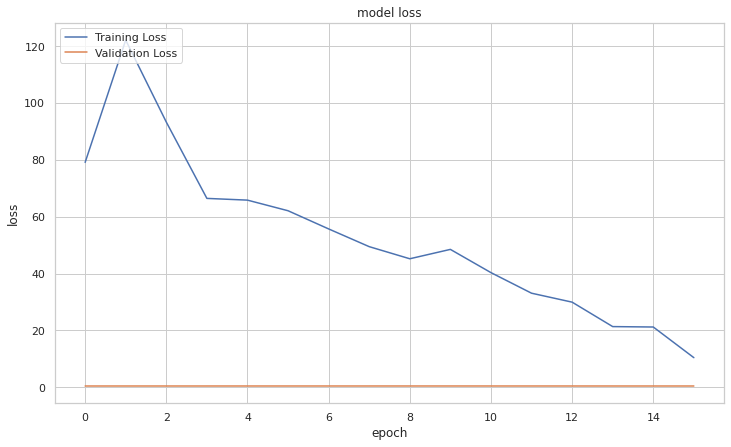

In [125]:
# summarize history loss
print(history.history.keys())
print(history.history)
print(history.history['val_loss'])
print(history.history['loss'])
plt.figure(figsize=(12,7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.savefig('{directory}/model_loss.png'.format(directory=directory), dpi=300, bbox_inches = 'tight', pad_inches=1)
plt.show()

## Save model

In [126]:
# datetime object containing current date and time
now = datetime.now()
timestamp = now.strftime("%Y-%m-%d_%H-%M")
timestamp

'2021-05-09_20-00'

In [127]:
# savefile = "/content/drive/MyDrive/Colab Notebooks/BRUNEI/multivariate_model_{}".format(timestamp)
savefile = "{directory}/model_{timestamp}".format(directory=directory,timestamp=timestamp)

model.save(savefile, save_format="h5")
# model.model.save('model')

# Forecast

In [128]:
#Forecasting
#Start with the last day in training date and predict future...
forecast_period_dates = pd.date_range(list(train_dates)[-10], periods=n_future, freq='1D').tolist()

In [129]:
n_future

150

In [130]:
forecast = model.predict(trainX[-n_future:]) #forecast 

#Perform inverse transformation to rescale back to original range
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)

In [131]:
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]
y_pred_future = y_pred_future
y_pred_future

array([0.47696003, 0.47731885, 0.4775434 , 0.47732675, 0.47714636,
       0.47715092, 0.47731915, 0.47762853, 0.47811052, 0.4788051 ,
       0.4795801 , 0.48043808, 0.48113495, 0.48159212, 0.48189983,
       0.48187953, 0.48141128, 0.4804391 , 0.47907984, 0.47723964,
       0.47485772, 0.4723956 , 0.47055137, 0.46925718, 0.46840718,
       0.4678796 , 0.46757507, 0.46739912, 0.4673075 , 0.46728235,
       0.46731055, 0.4672834 , 0.4671133 , 0.46683055, 0.46678123,
       0.4675096 , 0.46892685, 0.47059008, 0.4722431 , 0.47367162,
       0.47481433, 0.4756731 , 0.47627458, 0.47666693, 0.47692743,
       0.47706872, 0.47710615, 0.47709602, 0.47702244, 0.47691137,
       0.47672254, 0.47634697, 0.47582397], dtype=float32)

In [132]:
# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates[:len(y_pred_future)]), target_var:y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])
df_forecast['Date'] = df_forecast['Date']  + pd.Timedelta(days=1)
df_forecast.tail(10)

,Date,OSTotal
43,2021-04-15,0.476667
44,2021-04-16,0.476927
45,2021-04-17,0.477069
46,2021-04-18,0.477106
47,2021-04-19,0.477096
48,2021-04-20,0.477022
49,2021-04-21,0.476911
50,2021-04-22,0.476723
51,2021-04-23,0.476347
52,2021-04-24,0.475824


In [133]:
df_test['Date'] = test_dates

## Compare forecast with actual values 

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


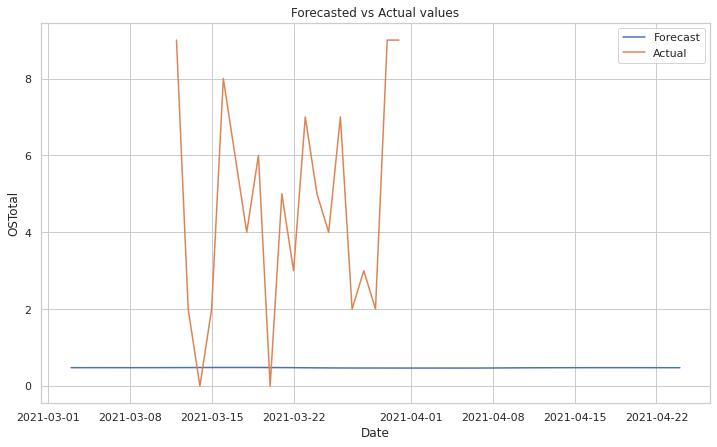

In [152]:
plt.figure(figsize=(12,7))
sns.lineplot(df_forecast['Date'], df_forecast[target_var], label = 'Forecast')
sns.lineplot(df_test['Date'], df_test[target_var], label='Actual')
# plt.ylim(0,200)
plt.legend()
plt.title('Forecasted vs Actual values')
plt.savefig('{directory}/forecast_vs_actual.png'.format(directory=directory), dpi=300, bbox_inches = 'tight', pad_inches=1)
plt.show()

## Error metrics

In [135]:
df_forecast[10:10+test_size][target_var].values

array([0.4795801 , 0.48043808, 0.48113495, 0.48159212, 0.48189983,
       0.48187953, 0.48141128, 0.4804391 , 0.47907984, 0.47723964,
       0.47485772, 0.4723956 , 0.47055137, 0.46925718, 0.46840718,
       0.4678796 , 0.46757507, 0.46739912, 0.4673075 , 0.46728235],
      dtype=float32)

In [136]:
y_pred = df_forecast[10:10+test_size][target_var].values
y_test = df_test[target_var].values

In [137]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)

Mean Squared Error: 25.464966090799578
Root Mean Squared Error: 5.046282402997238
Mean Absolute Error: 4.271141120791436


In [138]:
error_table = pd.DataFrame({'error_metric': ['MAE', 'MSE', 'RMSE']
                            , 'value': [mae, mse, rmse]})

error_table

,error_metric,value
0,MAE,4.271141
1,MSE,25.464966
2,RMSE,5.046282


# Model Explainer

In [139]:
pip install shap

In [140]:
import shap
shap.initjs()

In [141]:
import xgboost

[20:00:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


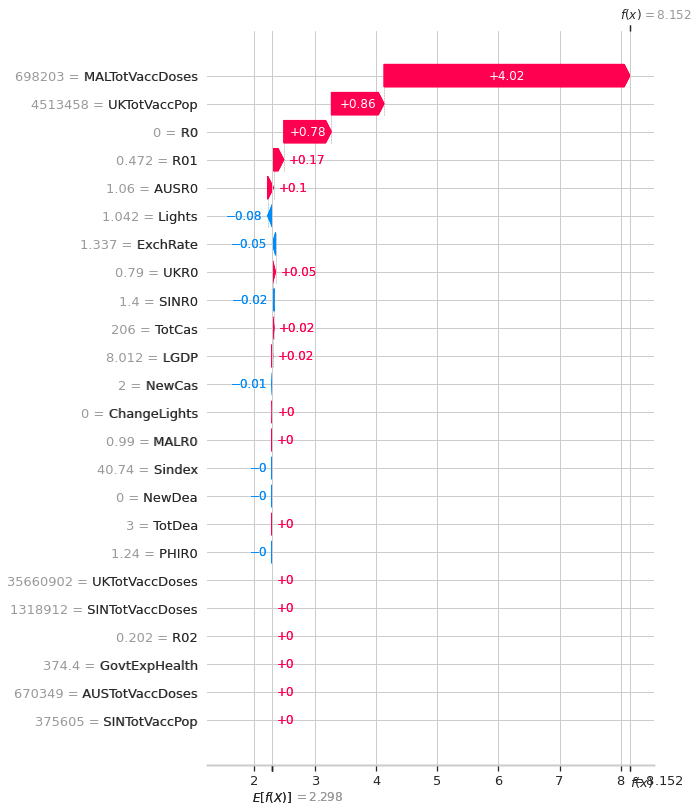

In [142]:
X = df.iloc[:,1:-1]
y = df.iloc[:,-1]
xgmodel = xgboost.XGBRegressor().fit(X, y)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(xgmodel)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[-1], max_display=25, show=False)
plt.savefig('{directory}/shap_latest_date.png'.format(directory=directory), dpi=300, bbox_inches = 'tight', pad_inches=1)
shap.plots.waterfall(shap_values[-1], max_display=25, show=False)

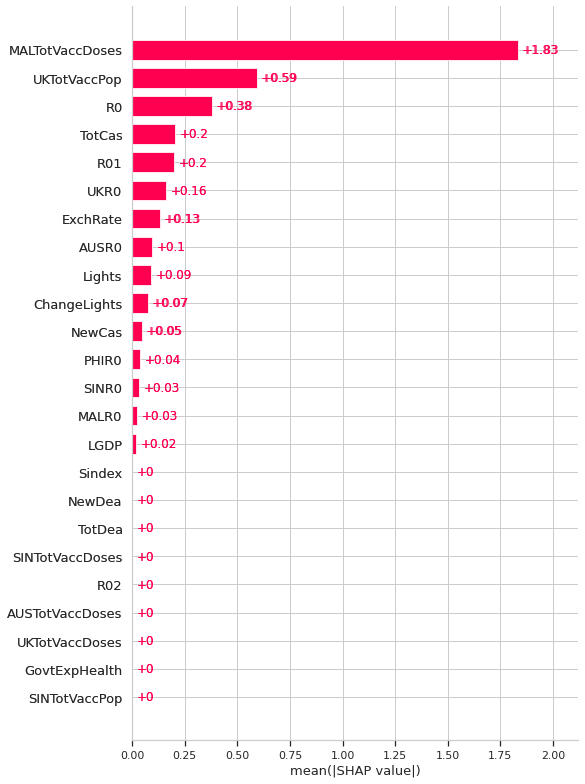

In [143]:
shap.plots.bar(shap_values[-20:], max_display=25, show=False)
plt.savefig('{directory}/shap_latest_20_dates.png'.format(directory=directory), dpi=300, bbox_inches = 'tight', pad_inches=1)
shap.plots.bar(shap_values[-20:], max_display=25, show=False)

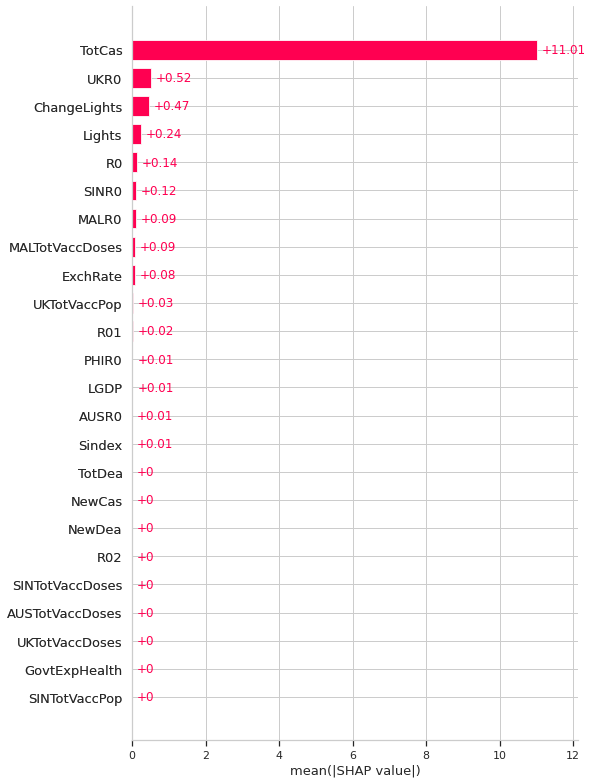

In [144]:
shap.plots.bar(shap_values[:10], max_display=25, show=False)
plt.savefig('{directory}/shap_first_20_dates.png'.format(directory=directory), dpi=300, bbox_inches = 'tight', pad_inches=1)
# shap.plots.bar(shap_values[:10], max_display=25)

# Save all parameters and results to a folder 

In [145]:
plt.savefig('{directory}/forecast_vs_actual.png'.format(directory=directory), dpi=300, bbox_inches = 'tight', pad_inches=1)


<Figure size 432x288 with 0 Axes>

In [146]:
with open('{directory}/parameters.csv'.format(directory=directory), 'w', newline = '') as csvfile:
    my_writer = csv.writer(csvfile, delimiter = ' ')
    my_writer.writerow(['filepath,', filepath])
    my_writer.writerow(['skiprows,', str(skiprows)])
    my_writer.writerow(['skipfooter,', str(skipfooter)])
    my_writer.writerow(['drop_columns,', drop_columns])
    my_writer.writerow(['target_var,', target_var])
    my_writer.writerow(['test_size,', test_size])
    my_writer.writerow(['n_future,', n_future])
    my_writer.writerow(['n_past,', n_past])
    my_writer.writerow(['lr,', lr])
    my_writer.writerow(['target_var,', target_var])
    my_writer.writerow(['model.summary,', str(model.summary())])
    

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 200, 50)           15200     
_________________________________________________________________
lstm_9 (LSTM)                (None, 200, 40)           14560     
_________________________________________________________________
lstm_10 (LSTM)               (None, 200, 20)           4880      
_________________________________________________________________
lstm_11 (LSTM)               (None, 10)                1240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 35,891
Trainable params: 35,891
Non-trainable params: 0
__________________________________________________

In [147]:
from contextlib import redirect_stdout

with open('{directory}/model_summary.txt'.format(directory=directory), 'w') as f:
    with redirect_stdout(f):
        model.summary()

In [148]:
df.to_csv('{directory}/final_df.csv'.format(directory=directory))

In [149]:
df_forecast.to_csv('{directory}/df_forecast.csv'.format(directory=directory))

In [150]:
df_test.to_csv('{directory}/df_test.csv'.format(directory=directory))

In [151]:
error_table.to_csv('{directory}/error_table.csv'.format(directory=directory))

In [160]:
pd.merge(df_forecast, df_test[['Date', target_var]], how='outer', on='Date', suffixes=['forecast', 'actual']).to_csv('{directory}/forecast_vs_actual.csv'.format(directory=directory))